<a href="https://colab.research.google.com/github/wizard339/education/blob/main/ensembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Решающие деревья

## 1. Решающее дерево
Решающее дерево (дерево решений) $-$ это функция от объекта в его признаковом описании. Ее значение вычисляется путем прохода некоторого дерева от корня к листу. Переход по дереву происходит путем принятия решения в узле дерева. 

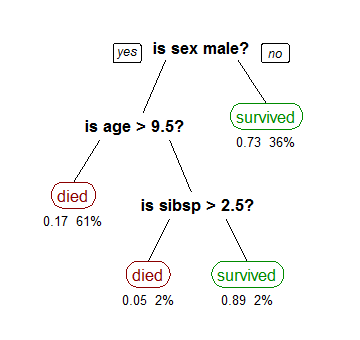

In [ ]:
from IPython.display import Image
Image('./CART_tree_titanic_survivors.png')

За счет такого представления результат дерева возможно проинтерпретировать. Например, согласно дереву выше значение `Survived` принимается согласно логическому условию: `Sex == "female" | ((Age > 9.5) & (Sibsp > 25))`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

# Для отрисовки деревьев
import pydotplus
from IPython.display import Image

Давайте попробуем классифицировать точки на плоскости.

In [2]:
n_points = 2000
x = np.vstack([np.random.normal(loc=1, size=(n_points, 2)),
               np.random.normal(loc=-1, size=(n_points, 2))])
y = np.array([0] * n_points + [1] * n_points)

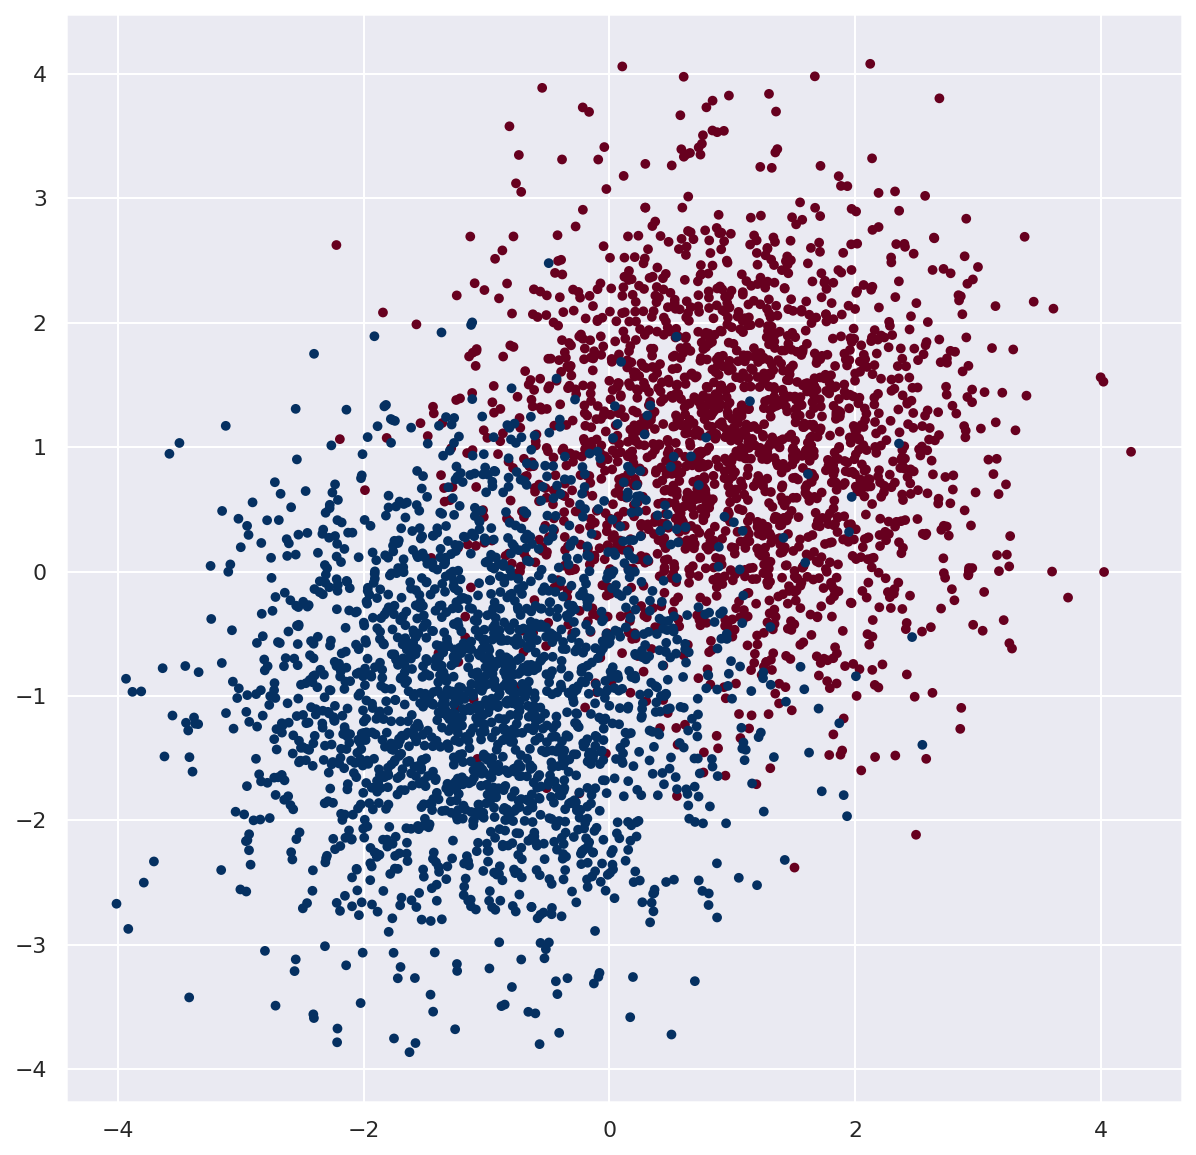

In [3]:
plt.figure(figsize=(10.0, 10.0))
plt.scatter(x[:, 0], x[:, 1], c=y, s=15, cmap=plt.cm.RdBu);

Следующие функции рисуют разделяющую поверхность модели и структуру дерева.

In [4]:
def plot_predictions(X, y, clf, proba=False, points_size=7):
    """Fits the classifier on the data (X, y) and plots the result on a 2-D plane."""
    def get_grid(data):
        x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
        y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
        return np.meshgrid(np.arange(x_min, x_max, 0.01),
                           np.arange(y_min, y_max, 0.01))
    
    clf.fit(X, y)
    xx, yy = get_grid(X)
    if proba:
        predicted = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
    else:
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        
    plt.figure(figsize=(10.0, 10.0))
    plt.pcolormesh(xx, yy, predicted, cmap=plt.cm.RdBu, alpha=0.1, shading='auto')
    plt.scatter(X[:, 0], X[:, 1], c=y, s=points_size, cmap=plt.cm.RdBu, alpha=0.90)
    plt.ylim([yy.min(), yy.max()])
    plt.xlim([xx.min(), xx.max()])
    plt.xlabel('x1')
    plt.ylabel('x2')
    
    return clf

def plot_tree(model, features, max_depth, out_file='tree.tmp'):
    dot_data = export_graphviz(decision_tree=model, out_file=out_file,
                               max_depth=max_depth, feature_names=features,
                               class_names=['0', '1'], filled=True, rounded=True,
                               special_characters=True,
                               proportion = True, precision=2,
                               label='all', impurity=False)  

    graph = pydotplus.graphviz.graph_from_dot_file(out_file)  
    return Image(graph.create_png())

Обучим дерево и посмотрим на него.

In [5]:
from sklearn.linear_model import LogisticRegression

LogisticRegression(C=0.001)

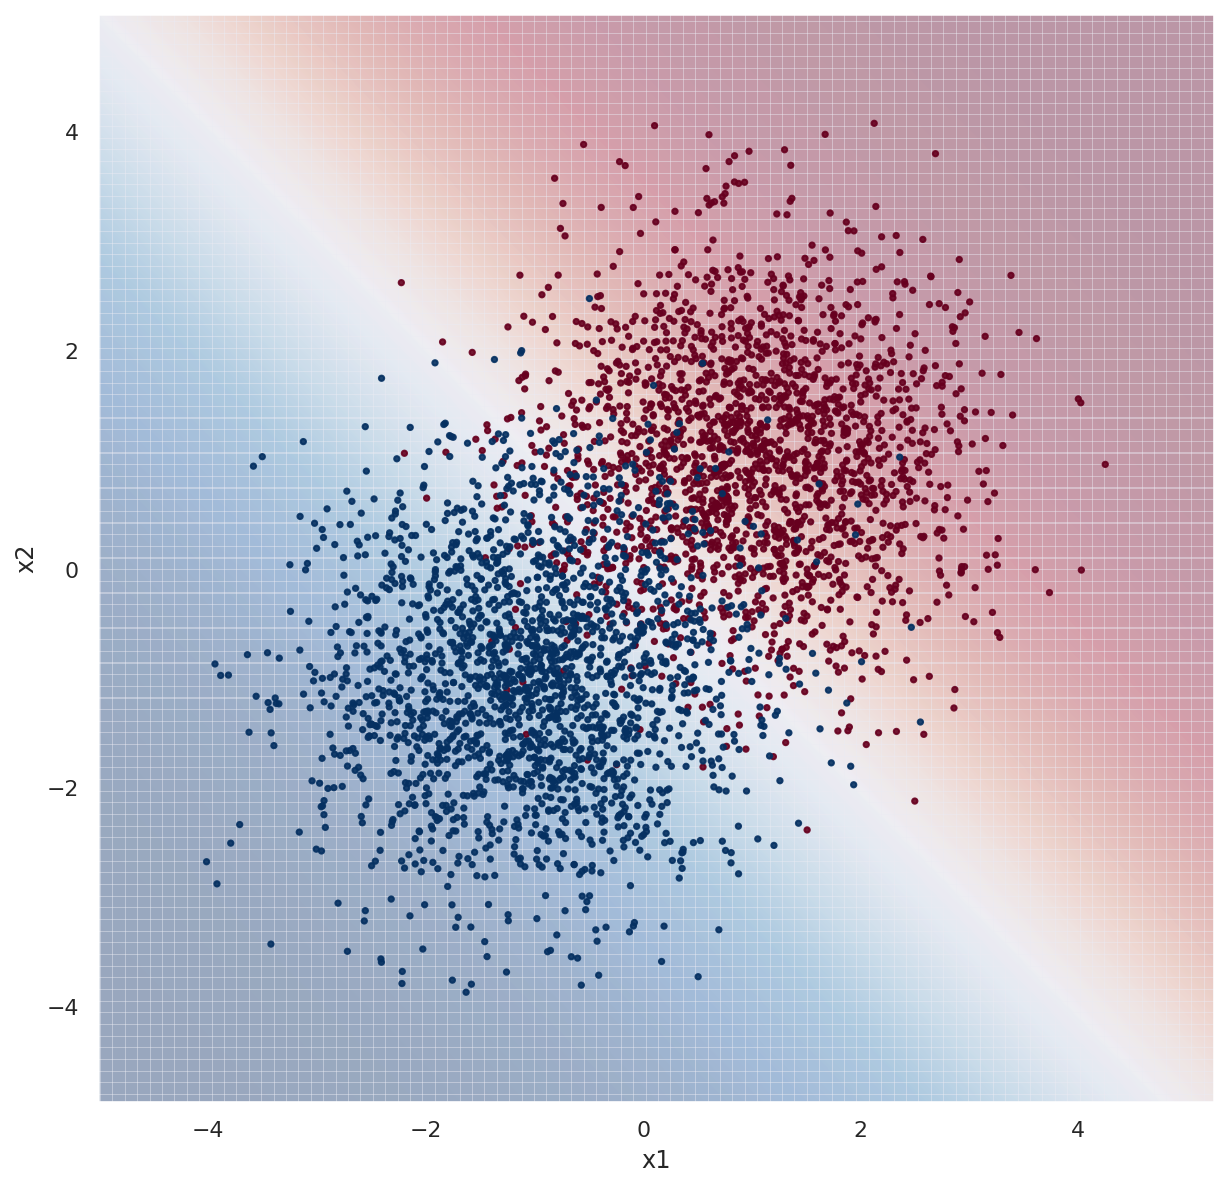

In [6]:
plot_predictions(x, y, LogisticRegression(C=0.001), proba=True)

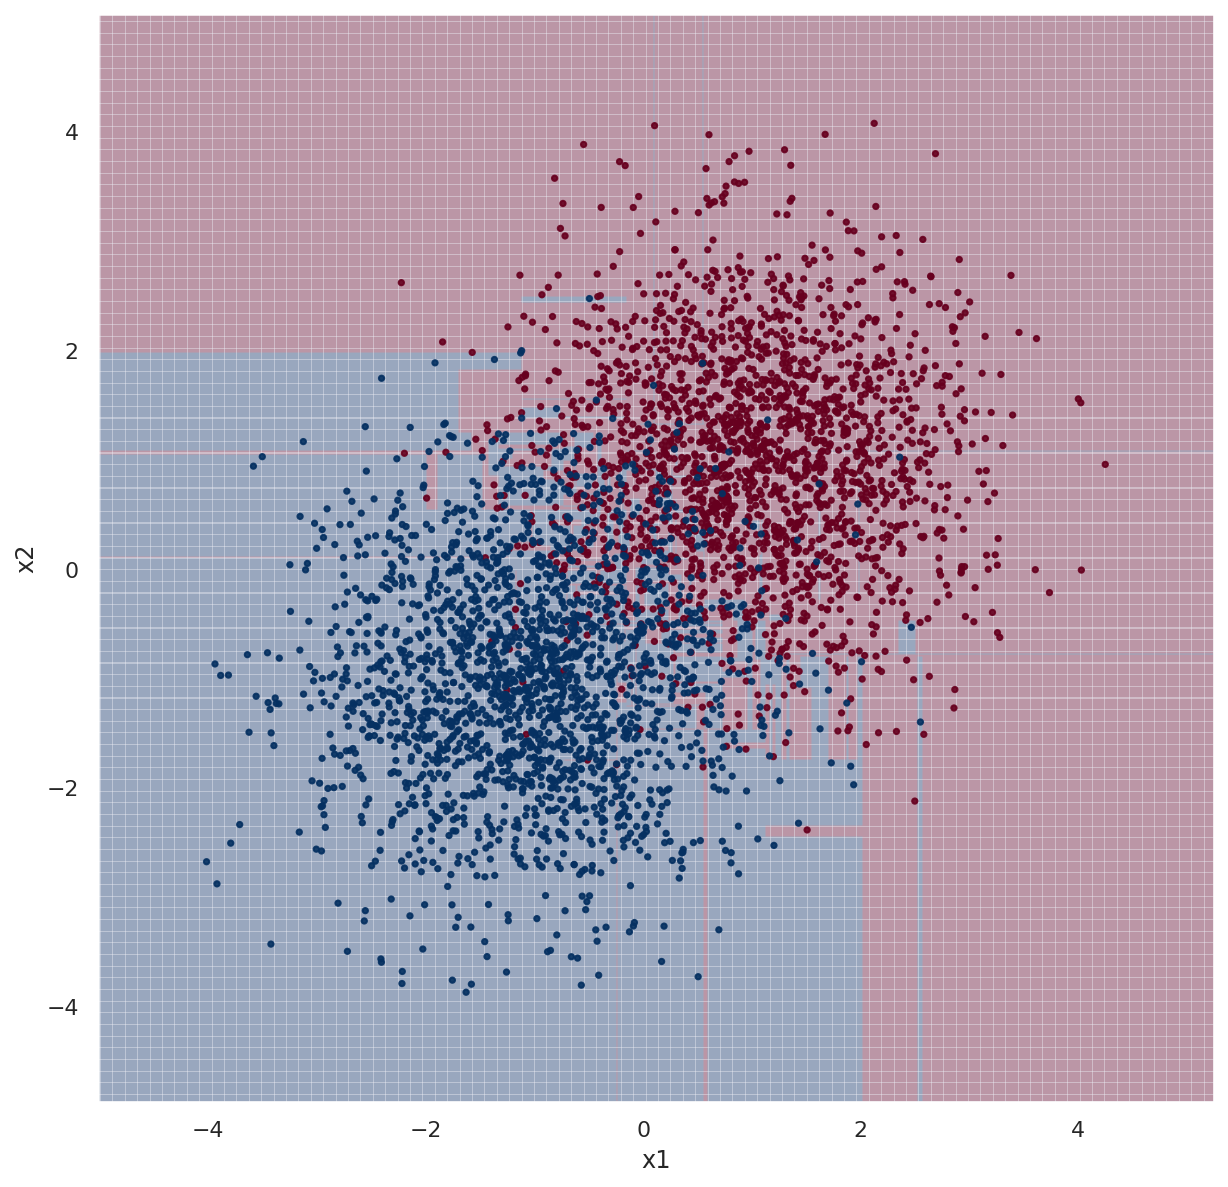

In [7]:
tree = DecisionTreeClassifier(max_depth=None)
plot_predictions(x, y, tree, proba=True);

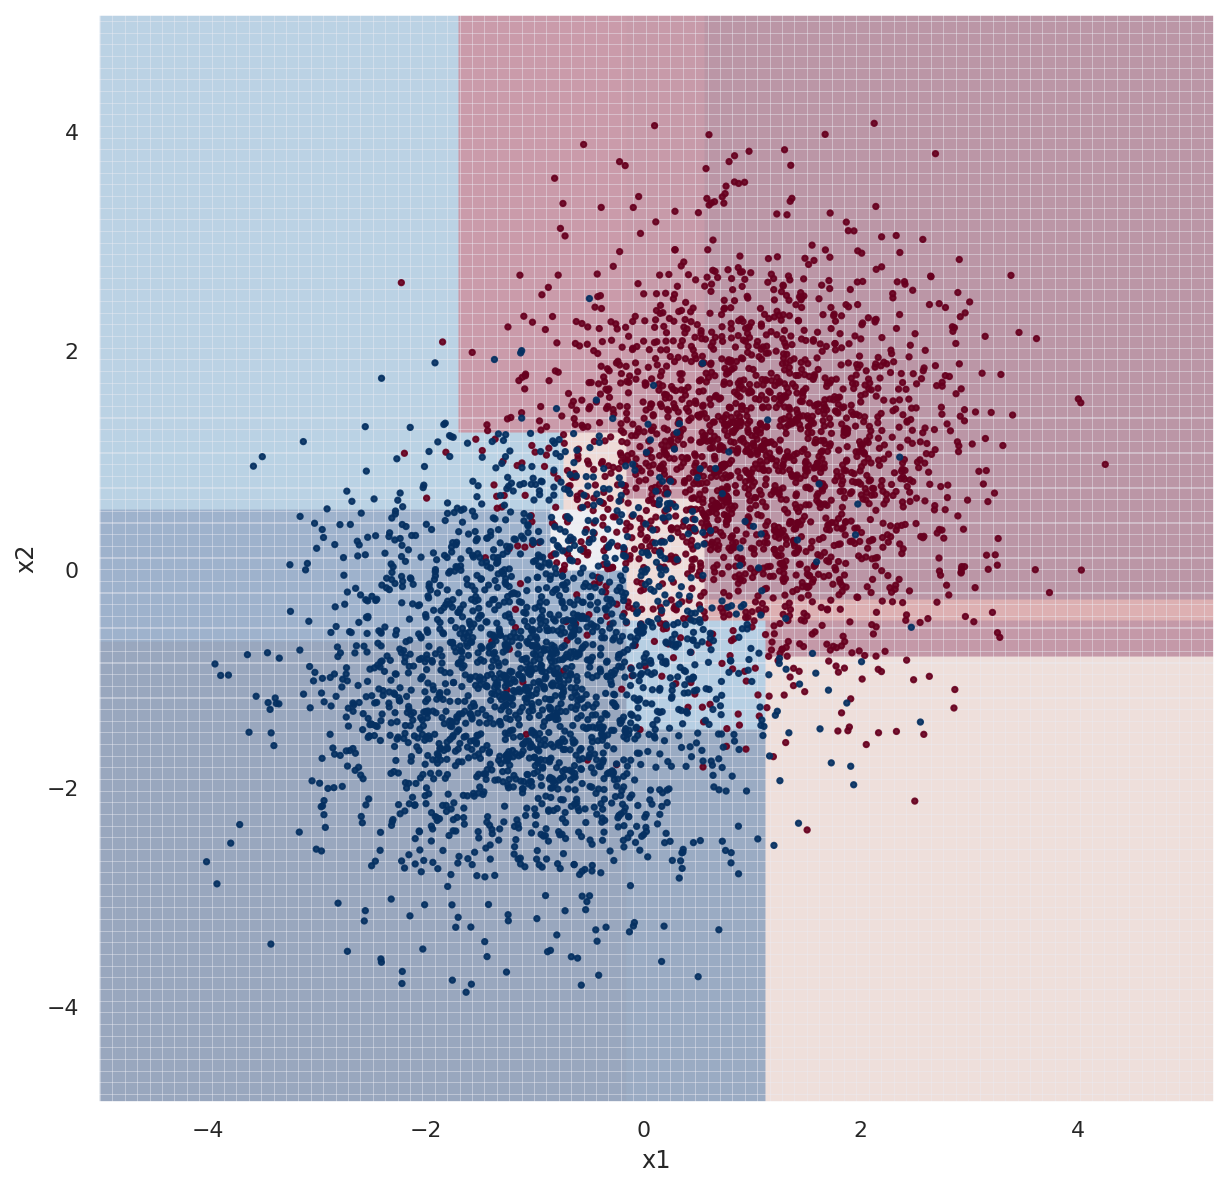

In [8]:
tree = DecisionTreeClassifier(max_depth=4)
plot_predictions(x, y, tree, proba=True);

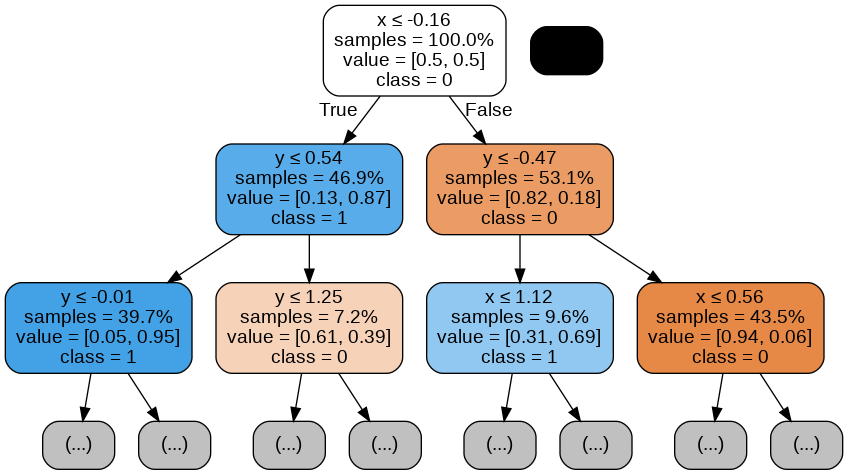

In [9]:
plot_tree(tree, ['x', 'y'], max_depth=2)

Если задать параметр `max_depth = None`, то видно что дерево переобучается: разделяющая поверхность строится на основе объектов-выбросов. Для борьбы с этим существуют несколько методов:
* ограничение структуры дерева: при построении дерево подчиняется ряду правил, например
    * ограничена максимальная высота (`max_depth`)
    * в листьях должно присутствовать как минимум какое-то число объектов (`min_samples_leaf`)
* усечение дерева: отрезание плохих вершин дерева  
Все эти методы эвристические и их качество борьбы с переобучением зависит от конкретных данных.

Рассмотрим виды деревьев, используемые на практике.  
В библиотеке CatBoost используются небрежные решающие деревья (Oblivious Trees). В них гарантированно на каждом слое дерева расположено одно и то же условие. За счет этого дерево можно представить многомерным массивом. 

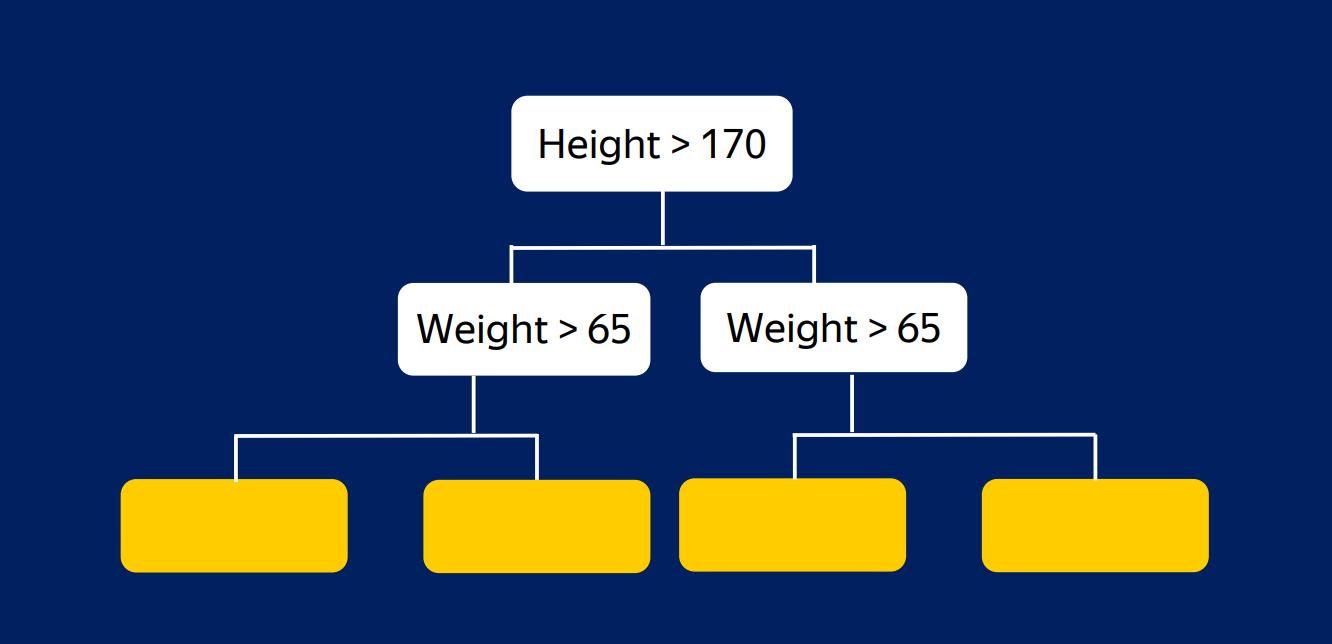

In [ ]:
Image('catboost.png')

В библиотеке LightGBM деревья строятся в глубину. Такие деревья можно представить как связный список.  

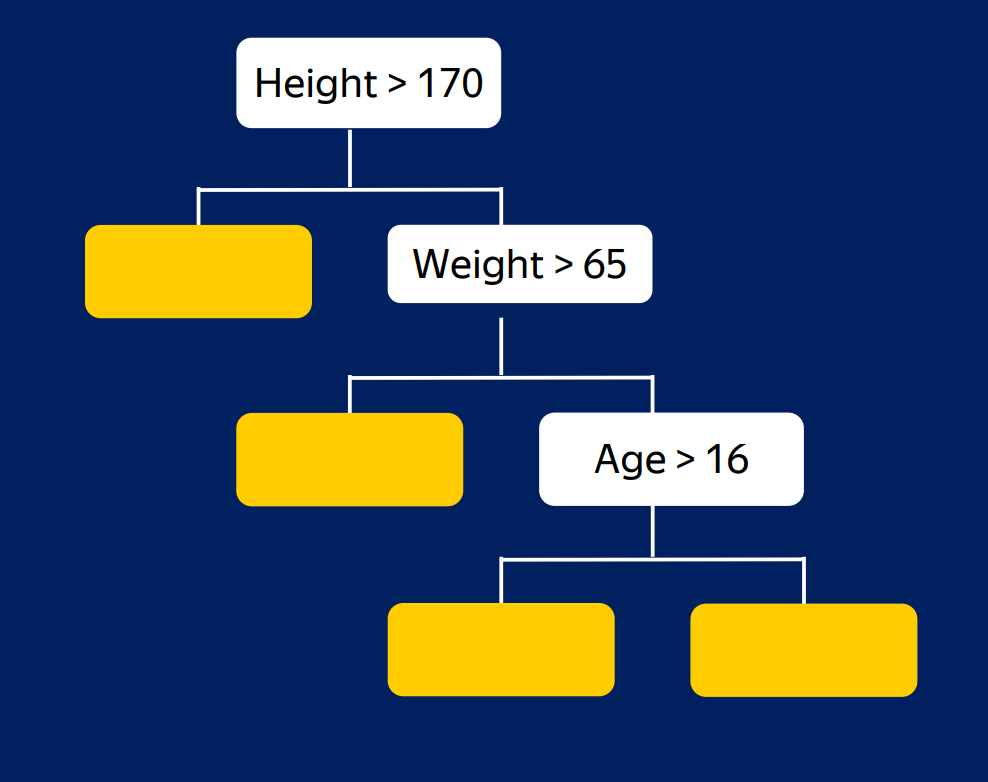

In [ ]:
Image('./lightgbm.png')

В известной библиотеке xgBoost используется усечение. В примере ниже правое дерево является усеченной версией левого. 

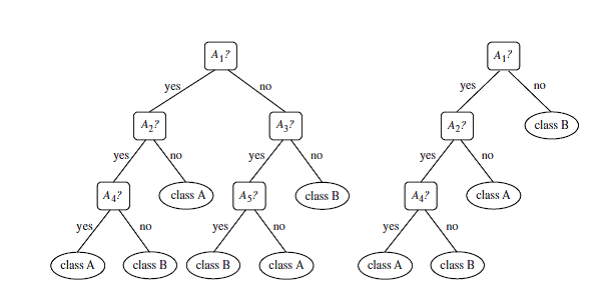

In [ ]:
Image('./pruning.png')

## 2. Построение решающего дерева

Для описания алгоритма потребуется несколько определений.

__Критерий информативности__ $-$ это величина, определенная для значений из обучающей выборки, попавших в лист дерева. Говорит о том, насколько хорошо работает предикат в этом листе. Рассмотрим некоторые из них.

### Критерии для задач классификации

#### Ошибка классификации
Частота ошибок при классификации наиболее мощным классом.  
$$H(R) = 1 - \max_{i}{p_i}$$


#### Энтропия
Это статистическая величина, измеряющая однорость данных. Низкая энтропия означает, что данные однородные, высокая $-$ что разнообразные. Она считается по следующей формуле.
 $$H(R)=\sum_{x \in X}{-p_R(x)\log_2 p_R(x)}$$
 $R$ $-$ данные  
 $X$ $-$ множество возможных значений данных  
 $p_R(x)$ $-$ частота $x$ в $R$
 
_Пример_:  
 Пусть в данных 0 встретился 1 раз, 1 встретилась 99 раз. Тогда энтропия равна
 $$H(R) = - 0.01 \cdot \log_2{0.01} - 0.99 \cdot \log_2{0.99} = 0.0808$$


#### Критерий Джини
Вероятность неправильной классификации, если предсказывать классы с вероятностями их появления в этом узле.  
$$H(R) = \sum_i p_i \cdot (1 - p_i)$$

### Критерии для задач регрессии

#### Средняя квадратичная ошибка (MSE) 
В случае деревьев и задачи регрессии адаптирована: ответ в листе равен среднему ответу среди ответов обучающей выборки, попавших в лист.

$$ H(R) = \frac{1}{R} \sum_{(x_i, y_i) \in R} \Big(y_i - \frac{1}{R} \sum_{(x_j, y_j) \in R} y_j \Big)^2 $$

Кроме MSE также используется **MAE**.
 
Любой алгоритм построения дерева сводится к минимизации того или иного критерия информативности. Заметим, что для любой выборки можно построить такое дерево, для которого ошибка на тренировочной выборке будет минимальна. Скорее всего такое дерево будет переобучено, поэтому следует строить деревья минимальной высоты. 

Найти идеальное дерево сложно, посколько для его построения требуется перебрать все возможные структуры деревьев. Поэтому обходятся жадными алгоритмами, то есть такими, которые на каждом шаге выбирают наилучшее в данный момент действие.

## Алгоритм C4.5
Этот алгоритм оперирует следующим понятием:  
*__Information Gain__* (рус. Выигрыш от ветвления, прирост информации). Условимся что для каждого признака $f$ можно получить разбиение множества $R$ на семейство непересекающихся подмножеств $\bigcup_i R_i$. Тогда:
$$IG(R, f) = H(R) - \sum_{R_i \subset R} \frac{|R_i|}{|R|} H(R_i)$$    
Другими словами, Information Gain показывает насколько выгодно разбить множество $R$ с использованием признака $f$. Подбор конкретного правила для разбиения на основе признака $f - $ отдельная задача.  
Определен для энтропийного критерия информативности.

Сам алгоритм представляет собой череду вызовов процедуры роста дерева для листьев. Процедура роста дерева выглядит так:
 1. Найти признак с наибольшим $IG$.
 2. Разделить множество объектов по этому признаку.
 3. Повторить для каждого подмножества, если его энтропия не равна нулю.  

Почитать ещё: http://www.saedsayad.com/decision_tree.htm

Попробуем сами реализовать решающее дерево. Начнем с класса `Node`, рекурсивно представляющего его структуру.

In [10]:
class Node(object):
    """
    A Node in a Decision Tree.
    self._next_left <- self.predicate -> self._next_right
    """
    def __init__(self, class_label=None):
        self._next_left = None
        self._next_right = None
        self.predicate = None

        self.class_label = class_label

    def get_class_label(self, x):
        """Recursively compute a decision for `x` based on a tree structure."""
        if self.is_leaf():
            return self.class_label

        branch = self.predicate(x)
        if branch == 0:
            return self._next_left.get_class_label(x)
        else:
            return self._next_right.get_class_label(x)
        
    def __call__(self, u):
        return self.predicate(u)
        
    def is_leaf(self):
        return self.class_label is not None
        
    def set_left(self, node):
        self._next_left = node

    def set_right(self, node):
        self._next_right = node

    def set_predicate(self, predicate):
        self.predicate = predicate

Продолжим при реализацией класса `Predicate`, представляющего решающее правило.

In [11]:
class Predicate:
    """
    A decision rule in a Decision Tree:
    self.feature > self.border
    """
    def __init__(self, x, y):
        self.border = None
        self.feature = -1

        self.split_mask = None
        self.__find_border_and_feature(x, y)

    @staticmethod
    def __entropy(labels):
        """Computes entropy for values of a given array."""
        _, counts = np.unique(labels, return_counts=True)
        frequency = counts / counts.sum()
        return np.sum(-frequency * np.log2(frequency))

    def __calculate_information_gain(self, s0, *args):
        """Calculates IG for a split s_1, ..., s_k.
           :arg s0 - the whole set
           :arg args - split, such that s0 = union(s_1, ..., s_k) and
               for all i, j: intersection(s_i, s_j) = 0
        """
        return self.__entropy(s0.reshape(len(s0))) - np.sum([
            (arg.size / float(s0.size)) * self.__entropy(arg.reshape(len(arg)))
            for arg in args
        ])

    def __find_border_and_feature(self, x, y):
        """Computes an optimal feature and its border."""
        s0 = y
        max_i_gain = 0
        for feature in np.arange(0, x.shape[1]):
            for border in x[:, feature]:
                split_mask = self.__get_split_mask(x, border, feature)
                sl, sr = self.split(x, y, split_mask)
                i_gain = self.__calculate_information_gain(s0, sl[1], sr[1])
                if i_gain > max_i_gain:
                    max_i_gain = i_gain
                    self.border = border
                    self.feature = feature
                    self.split_mask = split_mask

    def split(self, x, y, split_mask=None):
        """
        Computes a two-fold split for (x, y) using split_array as a mask.
        :args x, y - data for splitting
        :arg split_mask - binary mask for splitting, False for left fold and True for right fold
        """
        if split_mask is None:  # Using optimal split
            split_mask = self.split_mask

        left_idx = np.where(split_mask == 0)[0]
        right_idx = np.where(split_mask == 1)[0]
        return (
            [x[left_idx], y[left_idx]],
            [x[right_idx], y[right_idx]]
        )

    @staticmethod
    def __get_split_mask(x, border, feature):
        return (x[:, feature] > border).astype(np.int8)

    def __call__(self, x):
        return self.__get_split_mask(x, self.border, self.feature)

Теперь построим классификатор, последовательно строящий дерево.

In [12]:
class CustomDecisionTreeClassifier:
    """Classifies objects via a Decision Tree."""
    def __init__(self, max_depth=3):
        self.max_depth = max_depth
        self.root = None

    def fit(self, x, y):
        self.root = self.__fit_id3(x, y, 1)

    def predict(self, x):
        return np.array([self.root.get_class_label(el.reshape(1, x.shape[1]))
                         for el in x], dtype=np.int8)

    def predict_proba(self, x):
        raise NotImplementedError('TODO: implement storing of class frequences'
                                  'during the search of an optimal feature and border')

    def __fit_id3(self, x, y, level):
        class_labels = np.unique(y)
        # if there is only one class in y then return leaf node
        if class_labels.size == 1:
            return Node(class_label=class_labels[0])

        # find the most informative predicate and split by them
        beta = Predicate(x, y)
        to_left, to_right = beta.split(x, y)

        # if one of arrays is empty after split then return leaf node
        if to_left[0].size == 0 or to_right[0].size == 0 or level > self.max_depth:
            labels, counts = np.unique(y, return_counts=True)
            class_label = labels[counts.argmax(axis=0)]
            return Node(class_label=class_label)

        node = Node()
        node.set_predicate(beta)

        node.set_left(self.__fit_id3(to_left[0], to_left[1], level + 1))
        node.set_right(self.__fit_id3(to_right[0], to_right[1], level + 1))

        return node

In [13]:
tree = CustomDecisionTreeClassifier(max_depth=3)

In [14]:
tree.fit(x, y)

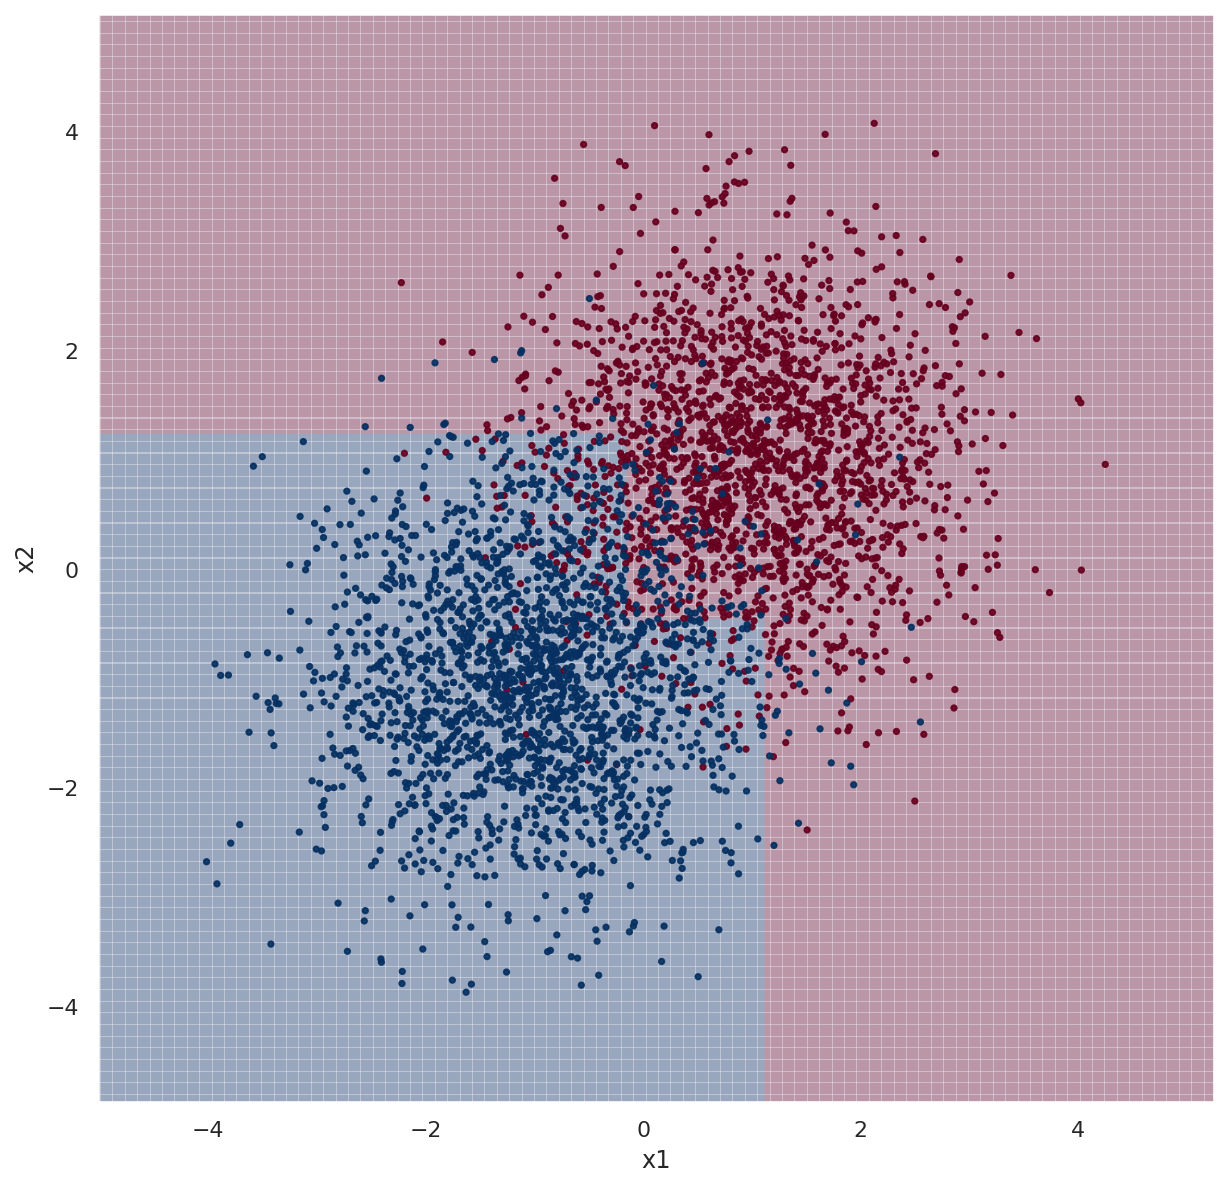

In [15]:
plot_predictions(x, y, tree);

Решающие деревья могут в том числе быть использованы для решения задачи регрессии. В таком случае они представляют собой кусочно-постоянную функцию.

In [16]:
x = np.linspace(-10, 10, num=150).reshape(-1, 1)
y = (x ** 2) * np.sin(x) + np.random.normal(scale=0.5)

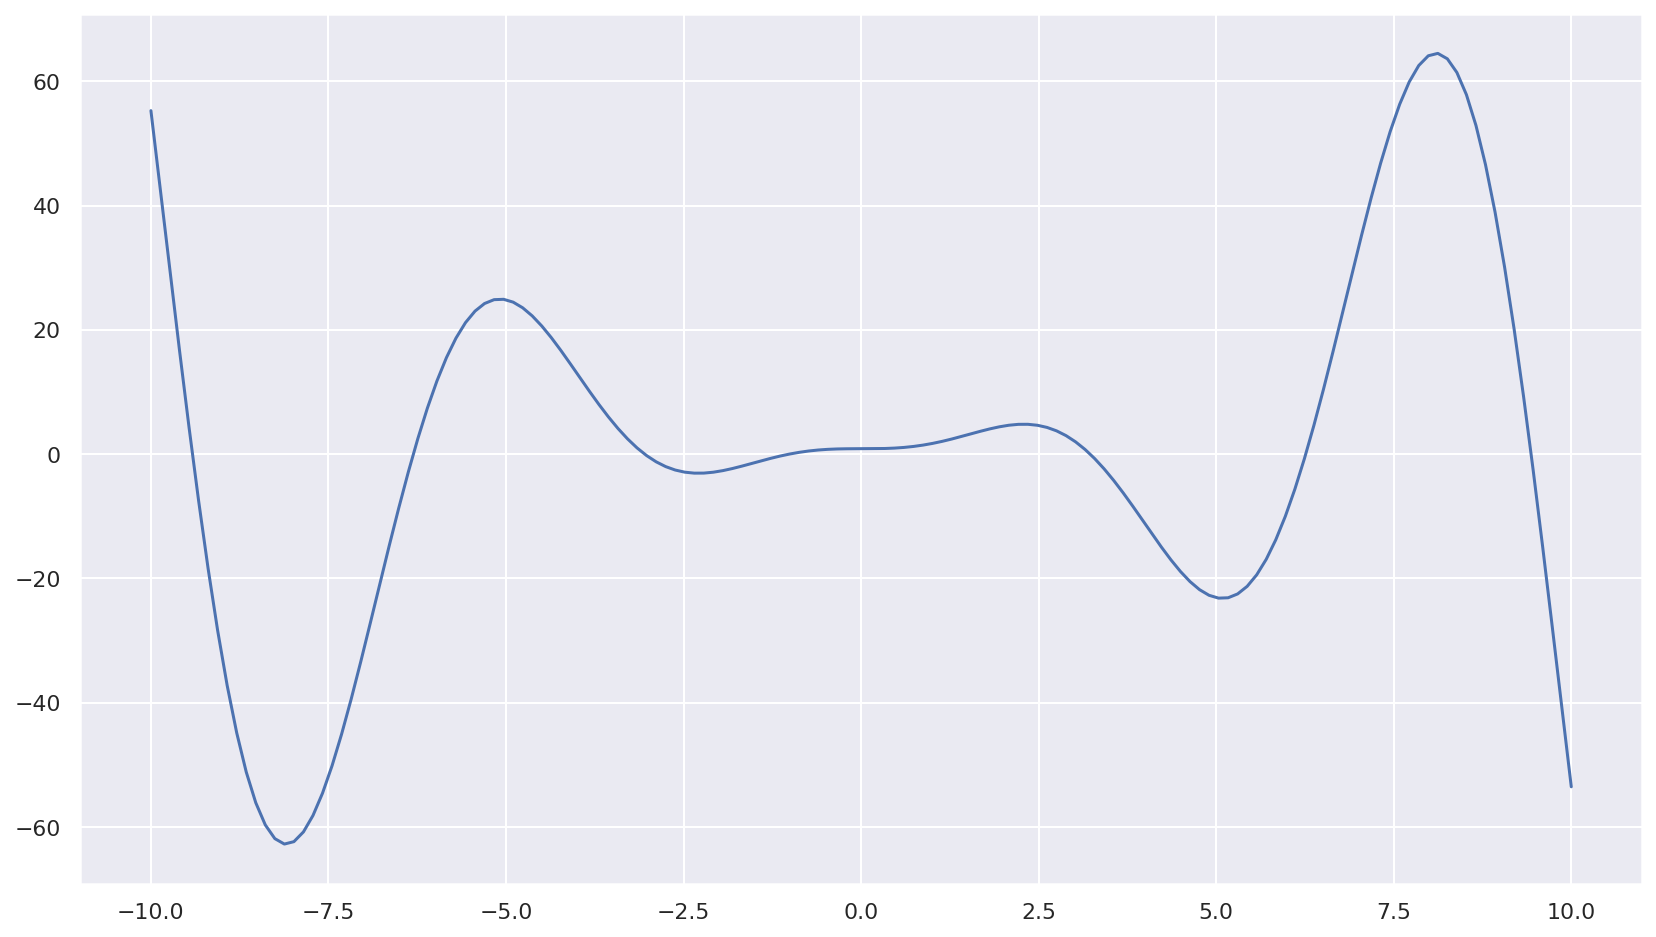

In [17]:
plt.figure(figsize=(14, 8))
plt.plot(x, y);

In [18]:
def plot_regressor_as_function(reg, x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=13)
    
    reg.fit(x_train, y_train)
    
    plt.figure(figsize=(14.0, 8.0))
    plt.plot(x_train, y_train, '.', c='C0', label='train')
    plt.plot(x_test, y_test, '.', c='C1', label='test')
    
    x_all = np.linspace(x.min(), x.max(), num=100)
    plt.plot(x_all, reg.predict(x_all.reshape(-1, 1)), c='C2', label='prediction')    
    plt.legend()

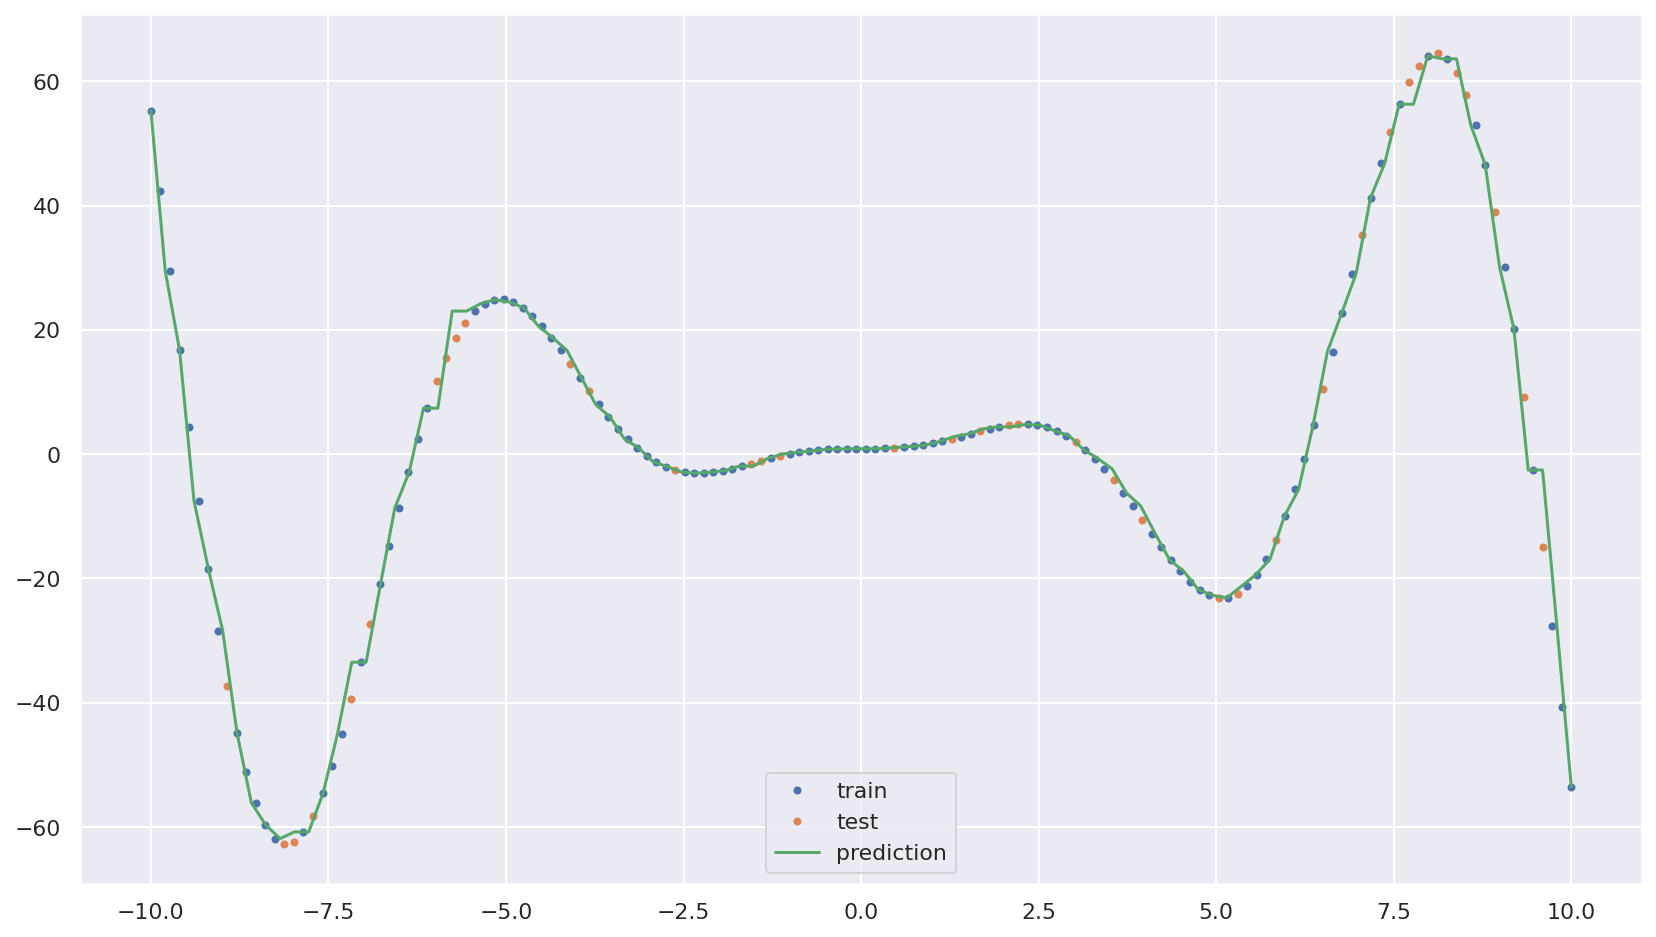

In [19]:
reg = DecisionTreeRegressor(max_depth=100)
plot_regressor_as_function(reg, x, y)

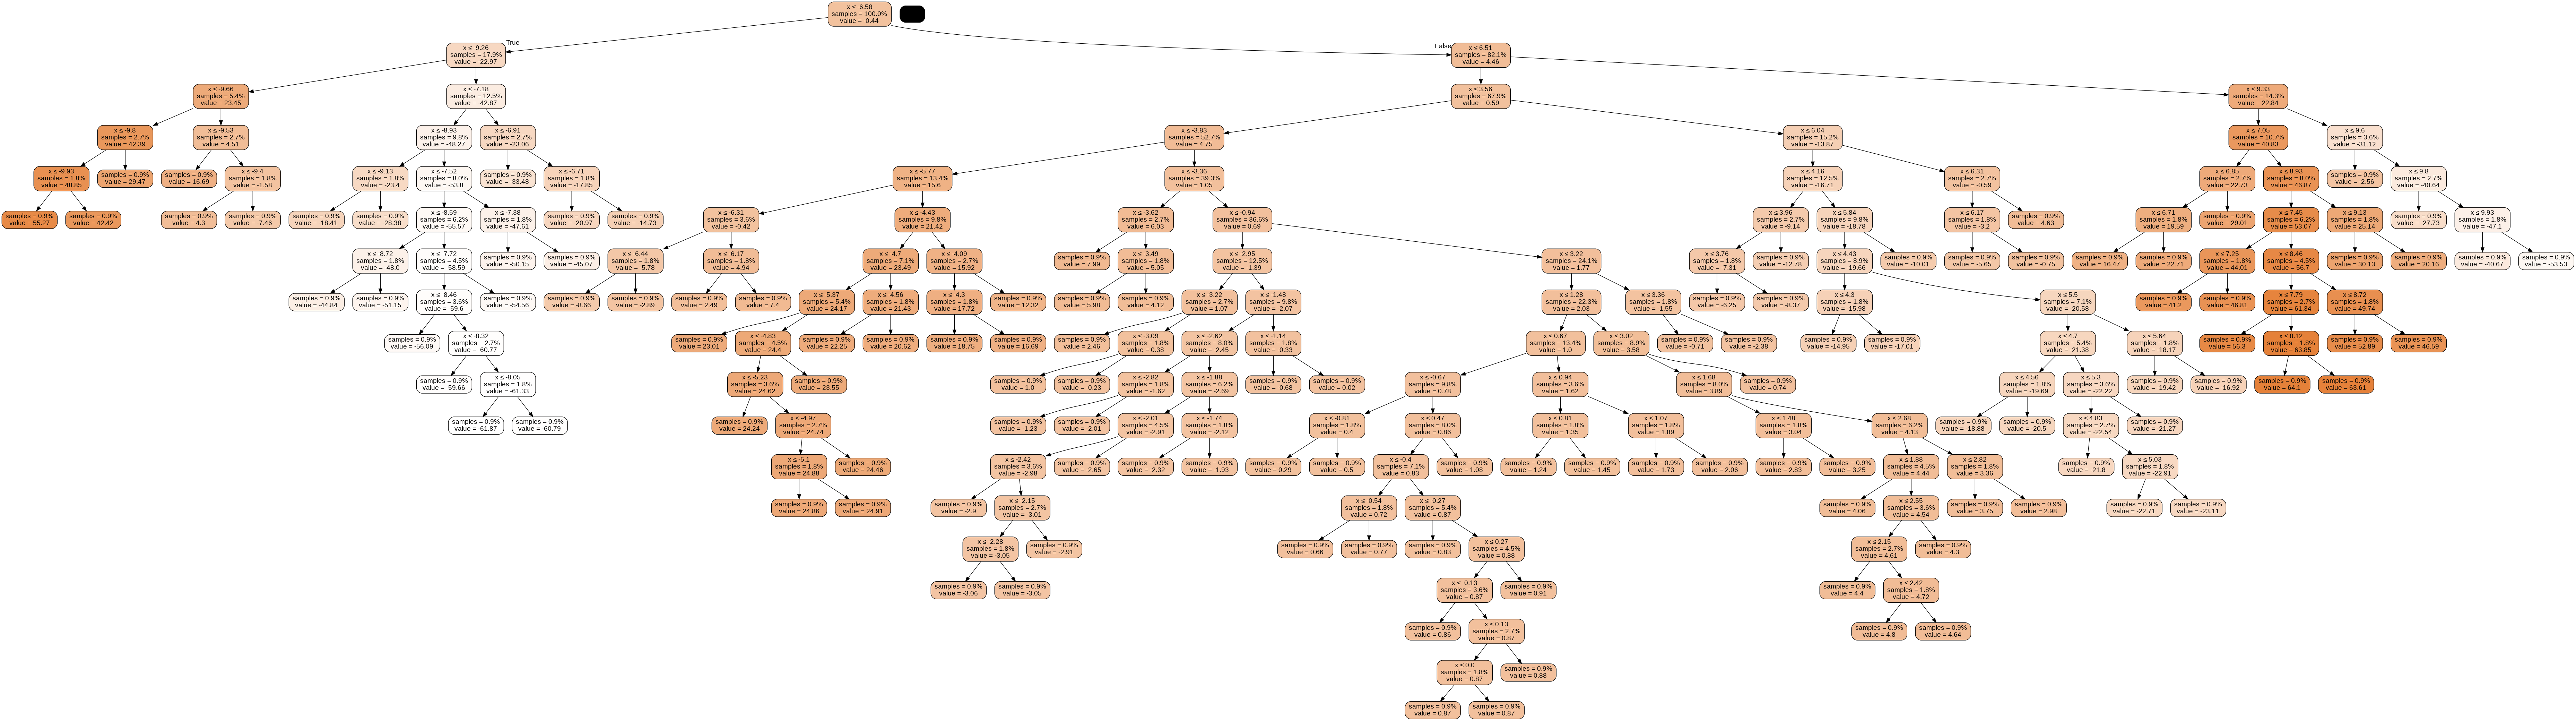

In [20]:
plot_tree(reg, ['x'], max_depth=None)

Дополнительная литература:
* Презентация Анны-Вероники Дорогуш про CatBoost, Computer Science Center: https://www.youtube.com/watch?v=UYDwhuyWYSo
* Немного описания про алгоритм построения дерева в LightGBM: https://lightgbm.readthedocs.io/en/latest/Features.html#optimization-in-accuracy
* Конспект лекции Соколова про решающие деревья: https://www.hse.ru/mirror/pubs/share/215285956

## 3. Ансамблирование алгоритмов

### Bagging

In [62]:
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler

np.random.seed(42)
sns.set()

Считаем данные: это показатели качества сотрудников некоторой компании. Построим модель, которая предсказывает уход сотрудника.

In [63]:
df = pd.read_csv('./HR-dataset.csv')
print(df.shape)
df.head()

(14999, 11)


empid  satisfaction_level  last_evaluation  number_project  \
0   1001                0.38             0.53               2   
1   1002                0.80             0.86               5   
2   1003                0.11             0.88               7   
3   1004                0.72             0.87               5   
4   1005                0.37             0.52               2   

   average_montly_hours  time_spend_company  Work_accident  left  \
0                   157                   3              0     1   
1                   262                   6              0     1   
2                   272                   4              0     1   
3                   223                   5              0     1   
4                   159                   3              0     1   

   promotion_last_5years   dept  salary  
0                      0  sales     low  
1                      0  sales  medium  
2                      0  sales  medium  
3                      0  sales     low  
4                      0  sales     low

In [64]:
target = 'left'
features = df.columns.drop(target)
print(features)

X, y = df[features].copy(), df[target]

Index(['empid', 'satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident',
       'promotion_last_5years', 'dept', 'salary'],
      dtype='object')


In [65]:
salary_ordinals = {'low': 1, 'medium': 2, 'high': 3}

X['dept'] = X['dept'].apply(X['dept'].value_counts().get)
X['salary'] = X['salary'].apply(salary_ordinals.get)

In [66]:
scaler = StandardScaler()
X = pd.DataFrame(data=scaler.fit_transform(X), columns=X.columns)

В дальнейшем будем оценивать качество модели на кросс-валидации на 5 фолдах при помощи точности (accuracy).

In [67]:
def estimate_accuracy(clf, X, y, cv=5):
    return cross_val_score(clf, X, y, cv=5, scoring='f1').mean()

Посмотрим на то, как работает бэггинг над решающими деревьями.  
__Бэггинг__ (bagging, bootstrap aggregating) $-$ метод построения композиции алгоритмов, в котором каждый алгоритм строится независимо от других на подвыборках обучающей выборки. Итоговый алгоритм принимает решения посредством голосования среди всех алгоритмов (возвращается самый частый ответ).

Посмотрим на точность одного дерева.

In [68]:
tree = DecisionTreeClassifier(max_depth=8)
print("Decision tree:", estimate_accuracy(tree, X, y))

Decision tree: 0.685284170420437


Проведем бэггинг: для этого достаточно обернуть исходный классификатор в `BaggingClassifier`.

In [69]:
bagging_trees = BaggingClassifier(tree)
print("Decision tree bagging:", estimate_accuracy(bagging_trees, X, y))

Decision tree bagging: 0.6848226168552396


Композиция отдельных деревьев показывает себя лучше чем одно дерево. Структура дерева сильно зависит от обучающей выборки, а значит что, если немного изменить обучающую выборку, то дерево сильно изменится. Бэггинг идеально подходит в этом случае, поскольку композиция алгоритмов при помощи голосования работает наилучшим образом, когда модели различны.

Увеличить различность построенных деревьев можно указав параметры `max_features` и `max_depth`.

In [70]:
random_tree = DecisionTreeClassifier(max_features=int(np.sqrt(len(features))), max_depth=8)
print("Random tree:", estimate_accuracy(random_tree, X, y))

Random tree: 0.6966034840604572


In [71]:
bagging_random_trees = BaggingClassifier(random_tree)
print("Random tree bagging:", estimate_accuracy(bagging_random_trees, X, y))

Random tree bagging: 0.7243392085096965


Именно так внутри и работает так называемый __случайный лес__ (Random Forest): он обучает набор деревьев (параметр `n_esimators`), каждое из которых обучается на подмножестве признаков (Random Subspaces) и на подмножестве объектов (bootstrap). Получается, что случайный лес случаен и по признакам, и по объектам. Ответы каждого дерева аггрегируются при помощи голосования.  
Стандартная эвристика: в задаче классификации брать квадратный корень числа признаков, а в задаче регрессии треть числа признаков.

In [72]:
random_forest = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    oob_score=True,
    max_features=int(np.sqrt(len(features))),
    max_depth=8)
print("Random Forest:", estimate_accuracy(random_forest, X, y))

Random Forest: 0.7282740559463396


Еще одно преимущество использования бэггинга для аггрегации моделей: получение оценки работы классификатора без дополнительного проведения кросс-валидации при помощи out-of-bag score.
__Out-of-bag score__ (OOB) $-$ это метод вычисления произвольной оценки качества во время обучения бэггинга. Для этого обученный на подвыборке алгоритм оценивается на тех примерах из всей обучающей выборки, который не попали в подвыборку.  
Для подсчета OOB требуется указать параметр `oob_score = True`. Его имеет смысл указать при достаточном количестве деревьев, иначе выдается ошибка.

In [73]:
random_forest = RandomForestClassifier(
    n_estimators=50,
    max_features=int(np.sqrt(len(features))),
    max_depth=5,
    oob_score=True
)
random_forest.fit(X, y)
random_forest.oob_score_.mean()

0.9804653643576239

Метод бэггинга можно применять к произвольным алгоритмам, например к логистической регрессии.

In [80]:
lr = LogisticRegression(solver='saga', max_iter=200)
lr.fit(X, y)
print("LR:", estimate_accuracy(lr, X, y))

LR: 0.3821770500319356


In [82]:
random_logreg = BaggingClassifier(
    lr,
    n_estimators=50,
    n_jobs=-1,
)
print("Bagging for LR:", estimate_accuracy(random_logreg, X, y))

Bagging for LR: 0.38358167203026283


В ее случае он не так сильно повышает качество, поскольку линейные модели не так сильно зависят от состава обучающей выборки.  
Однако, можно улучшить качество композиции, убрав часть признаков.

In [87]:
random_logreg = BaggingClassifier(
    lr,
    n_estimators=10,
    n_jobs=-1,
    max_features=4
)
print("Bagging for LR:", estimate_accuracy(random_logreg, X, y))

Bagging for LR: 0.12428833167634352


### Boosting

А теперь рассмотрим алгоритм AdaBoost. Основное его отличие от алгоритма Bagging заключается в том, что он строит сложный классификатор из последовательный предсказаний простых классификаторов. В качестве алгоритма по умолчанию используется "решающий пень" - решающее дерево глубины 1.

In [ ]:
boost_tree = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=50, 
    learning_rate=1
)
print("Bagging for LR:", estimate_accuracy(boost_tree, X, y))

Bagging for LR: 0.7423157052350783


В качестве слабых классификатором можно также использовать любой алгоритм, в том числе логистическую регрессию. 

In [ ]:
boost_logreg = AdaBoostClassifier(
    lr,
    n_estimators=50, 
    learning_rate=1
)
print("Bagging for LR:", estimate_accuracy(boost_logreg, X, y))

### Перебор параметров по сетке

In [89]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [90]:
cv = GridSearchCV(
    RandomForestClassifier(),
    param_grid={
        'max_depth': [3, 5, None],
        'n_estimators': [10, 50, 100]
    },
    cv=3, verbose=True,
    scoring='roc_auc'
)

In [91]:
cv.fit(X, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 5, None],
                         'n_estimators': [10, 50, 100]},
             scoring='roc_auc', verbose=True)

In [92]:
cv.best_estimator_

RandomForestClassifier()

### Сравнение логистической регрессии и случайного леса

In [93]:
def plot_predictions(X, y, clf, proba=False, points_size=7, xlabel='x', ylabel='y'):
    """Fits the classifier on the data (X, y) and plots the result on a 2-D plane."""
    def get_grid(data):
        x_std, y_std = data.std(axis=0)
        x_min, x_max = data[:, 0].min() - x_std / 2, data[:, 0].max() + x_std / 2
        y_min, y_max = data[:, 1].min() - y_std / 2, data[:, 1].max() + y_std / 2
        return np.meshgrid(np.linspace(x_min, x_max, num=200),
                           np.linspace(y_min, y_max, num=200))
    
    clf.fit(X, y)
    xx, yy = get_grid(X)
    if proba:
        predicted = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
    else:
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        
    plt.figure(figsize=(10.0, 10.0))
    plt.pcolormesh(xx, yy, predicted, cmap=plt.cm.coolwarm, alpha=0.1, shading='auto')
    plt.scatter(X[:, 0], X[:, 1], c=y, s=points_size, cmap=plt.cm.coolwarm, alpha=0.90)
    plt.ylim([yy.min(),yy.max()])
    plt.xlim([xx.min(),xx.max()])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    return clf

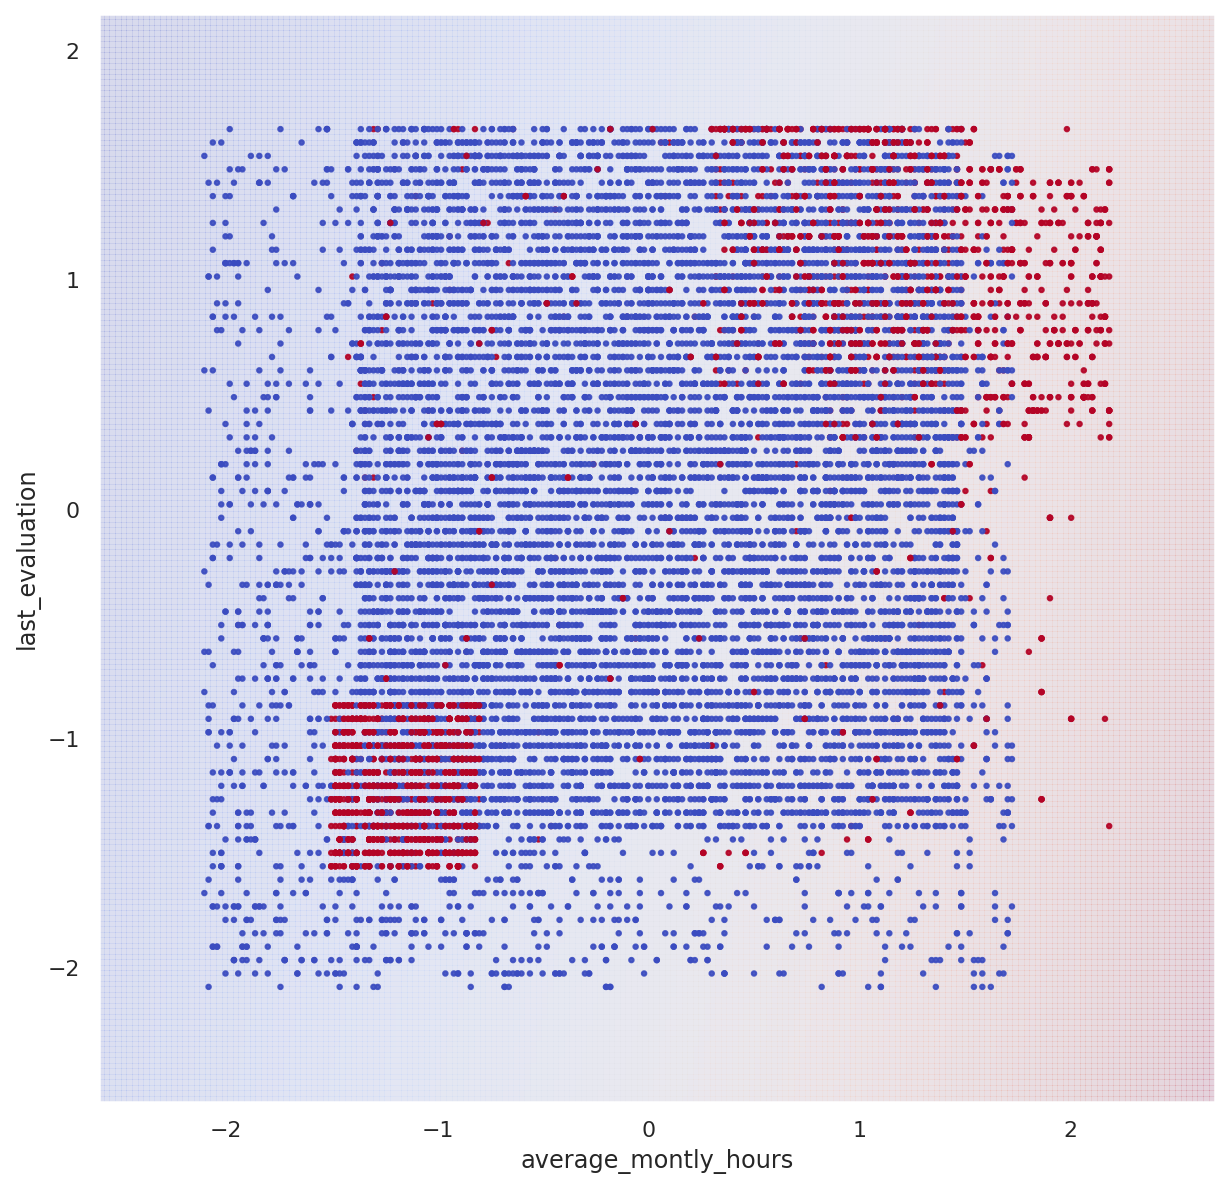

In [94]:
plot_predictions(X[['average_montly_hours', 'last_evaluation']].values, y,
                 LogisticRegression(),
                 points_size=5,
                 proba=True, xlabel='average_montly_hours', ylabel='last_evaluation');

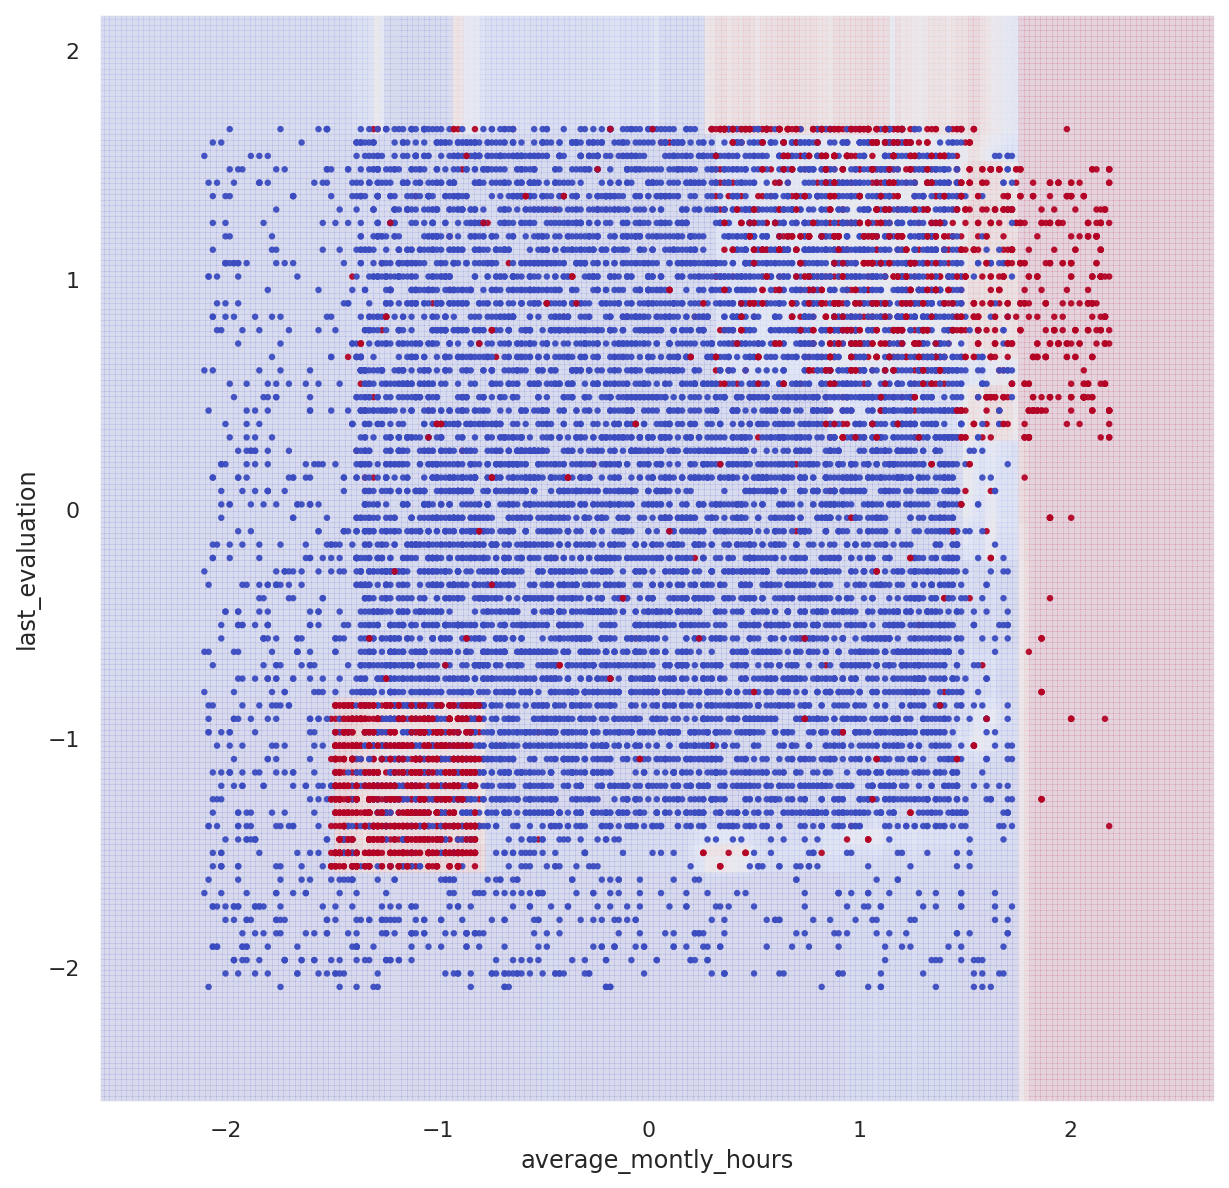

In [95]:
plot_predictions(X[['average_montly_hours', 'last_evaluation']].values, y,
                 RandomForestClassifier(
                     n_estimators=50,
                     max_features=2,
                     max_depth=8),
                 points_size=5,
                 proba=True, xlabel='average_montly_hours', ylabel='last_evaluation');

Что еще можно посмотреть:
* Изменение качества случайного леса в зависимости от числа деревьев: http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html